In [1]:
import os
import glob
import json
import xml.etree.ElementTree as ET

import cv2
import pandas
import openslide
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import chain
import matplotlib.pyplot as plt

from pyslide import slide, patching, Stitching
from pyslide.utilities import mask2rgb
from pyslide.preprocessing import calculate_weights, calculate_std_mean


In [2]:
#asap_path='data/annotations/asap_annotations.xml'
#imagej_path='data/annotations/imagej_annotations.xml'
#json_path='data/annotations/json_annotations.json'
#csv_path='data/annotations/csv_annotations.csv'
#WSI_PATH='/Volumes/cancerbioin/barts/lymphnode-paper-set/2865 B2 LN.ndpi'
QUPATH_PATH='/Users/w2030634/Projects/PySlide/data/annotations/qupath.json'
WSI_PATH='data/wsi/2865 B2 LN.ndpi'

border:[(3981.0, 118531.0), (11202.0, 92659.0)]


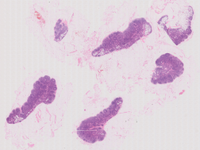

In [3]:
annotate=slide.Annotations([QUPATH_PATH],source="qupath",labels=['sinus','follicle','germinal centre'])
wsi=slide.Slide(WSI_PATH,mag=0,annotations=annotate)
mask=wsi.slide_mask
print('border:{}'.format(wsi.get_border()))
wsi.get_thumbnail((200,200))

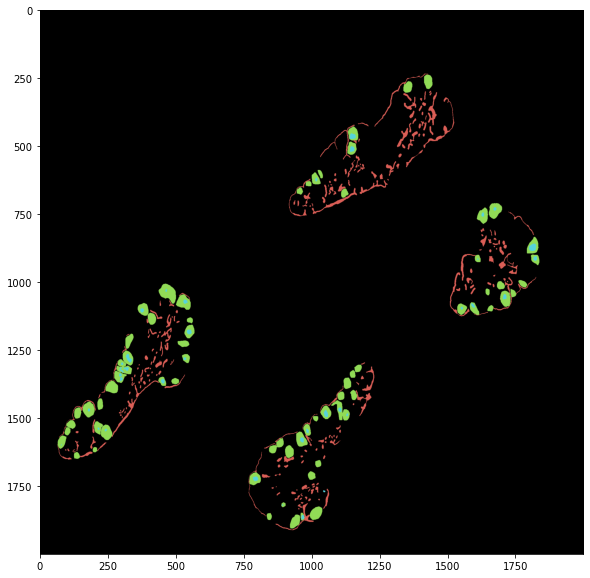

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(mask)

### Resize border 

In [15]:
print('border:{}'.format(wsi.get_border()))
borders=wsi.get_border()
x_new=wsi.resize_border(borders[0][0],factor=32)
x_new

border:[(3981.0, 118531.0), (11202.0, 92659.0)]


4000

### Detect components

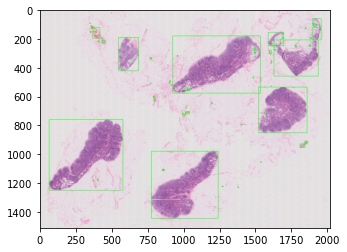

In [17]:
img,borders=wsi.detect_components()
plt.imshow(img[-1])

### Generate region

In [18]:
wsi.dimensions
border=borders[14]
(x1,x2),(y1,y2)=border
border

[(4032, 36864), (48576, 17152)]

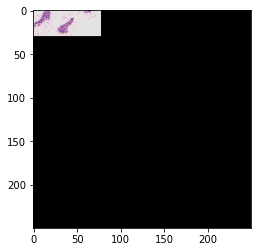

In [19]:
wsi2=openslide.OpenSlide(WSI_PATH)
region=wsi2.read_region((4032,48576),3,(50000,50000))
region_new=cv2.resize(np.array(region.convert('RGB')),(250,250))
plt.imshow(region_new)

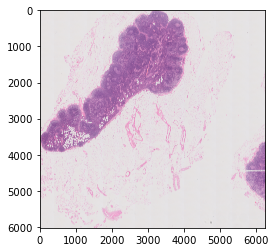

In [22]:
region=wsi.generate_region(mag=3,x=(x1,x2),y=(y1,y2),x_size=50000,y_size=50000)
plt.imshow(region[0])

## Patching

In [2]:
patch=patching.Patching(wsi,mag_level=3,step=1024,size=(1024,1024))
#patch.save('images',mask_flag=True)

NameError: name 'wsi' is not defined

### filter patches

Num removed: 73
Remaining:23


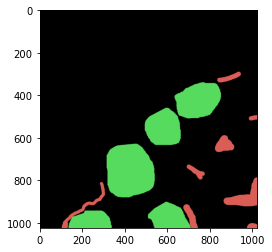

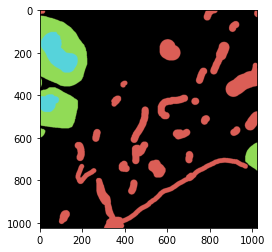

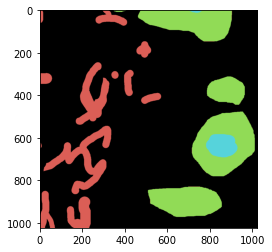

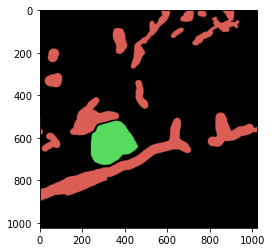

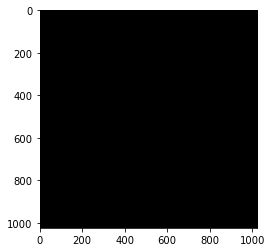

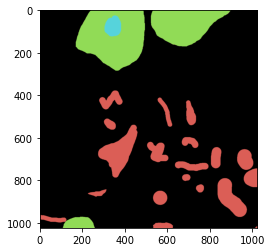

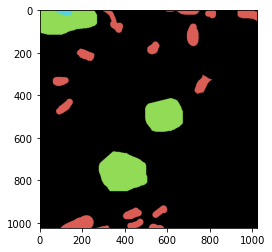

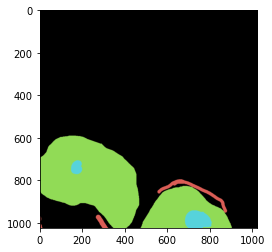

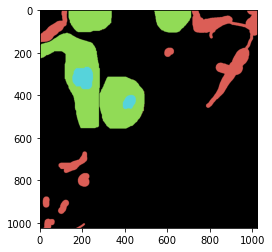

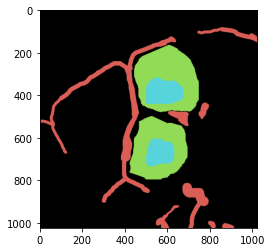

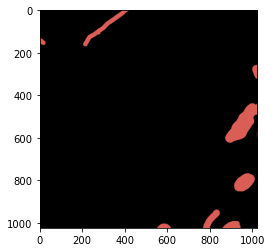

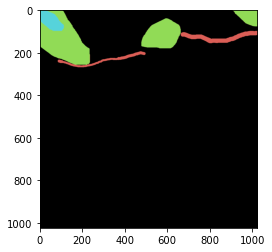

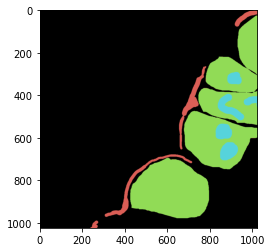

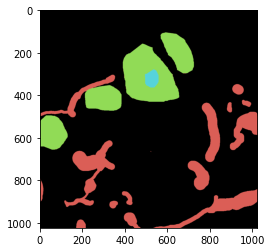

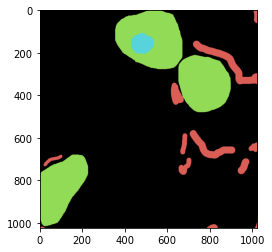

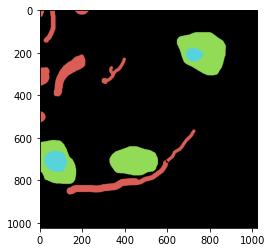

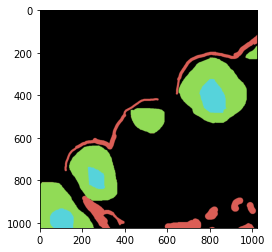

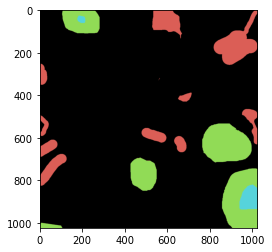

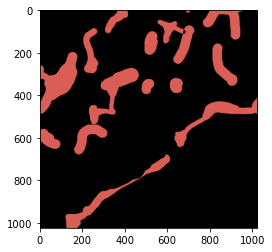

In [12]:
patch.filter_patches(210)
patch.save('images',mask_flag=True)
masks=glob.glob('images/masks/*')
for m in masks:
    mask=cv2.imread(m)
    mask=mask2rgb(mask[:,:,0])
    plt.imshow(mask)
    plt.show()

### Get labels

<AxesSubplot:>

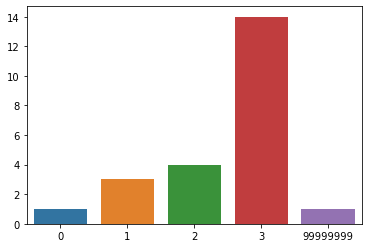

In [13]:
patch.generate_labels(0.5)
patch.plotlabeldist()

### Stitching

In [6]:
stitch=Stitching('images/images',name='2865 B2 LN.ndpi',mag_level=3)
canvas=stitch.stitch(size=(2500,2500))

found 96 patches
border [[12173, 102285], [19394, 76738]]
step 1024


In [ ]:
plt.imshow(canvas)

## Preprocessing 

In [4]:
calculate_weights(mask_path='images/masks',num_cls=4)

[1.1850617226198867,
 16.962905236030736,
 11.232883500960867,
 122.16584436767403]

In [2]:
calculate_std_mean('images/images')

[0. 0. 0.]
total number pixels: 24117248
mean: [0.74730681 0.59215717 0.75368948], std: [0.12720346 0.21965498 0.15878633]


(array([0.74730681, 0.59215717, 0.75368948]),
 array([0.12720346, 0.21965498, 0.15878633]))

### Missing

In [ ]:
image=np.array(wsi.get_thumbnail((1000,1000)))
plt.imshow(image)
plt.show()
hist1 = cv2.calcHist([image],[0],None,[256],[0,256])
hist2 = cv2.calcHist([image],[1],None,[256],[0,256])
hist3 = cv2.calcHist([image],[2],None,[256],[0,256])
plt.subplot(222), plt.plot(hist1), plt.plot(hist2),plt.plot(hist3)